In [1]:
import os
os.getcwd()

'/Users/rohitarora/Documents/Bose lab/OSCC_ST/Revisions_Dec2022_analysis/velocity'

In [2]:
import pandas as pd
import scvelo as scv
import scanpy as sc
import numpy as np
scv.logging.print_version()

Running scvelo 0.2.5 (python 3.9.12) on 2023-04-24 19:02.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


In [23]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

In [24]:
adata = scv.read('scvelo_oscc.loom')

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

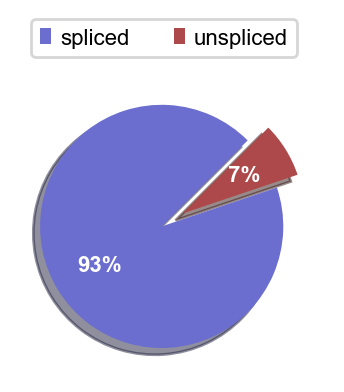

In [25]:
scv.pl.proportions(adata)

In [26]:
positions = pd.read_csv("positions_scvelo.csv")
positions = positions.tail(positions.shape[0] -1)
positions.index = positions.index.rename("CellID")
positions["CellID"] = positions["Barcodes"]
positions.drop("Barcodes", inplace=True, axis=1)
positions.index = positions["CellID"]
positions['UMAP_1'] = positions['UMAP_1'].astype('float32')
positions['UMAP_2'] = positions['UMAP_2'].astype('float32')

adata.obs = adata.obs.join(positions, how="left")

adata.obsm['umap'] = adata.obs[
            ['UMAP_1', 'UMAP_2']
        ].to_numpy()

adata.obs.drop(
            columns=['CellID', 'UMAP_1', 'UMAP_2'],
            inplace=True,
        )

meta = pd.read_csv("scvelo_metadata_headers.csv")
meta = meta.tail(meta.shape[0] -1)
meta["CellID"] = meta["Barcode"]
meta.drop("Barcode", inplace=True, axis=1)
meta.index = meta["CellID"]
adata.obs = adata.obs.join(meta, how="left")
adata = adata[adata.obs["orig.ident"] == "ST_OSCC"]


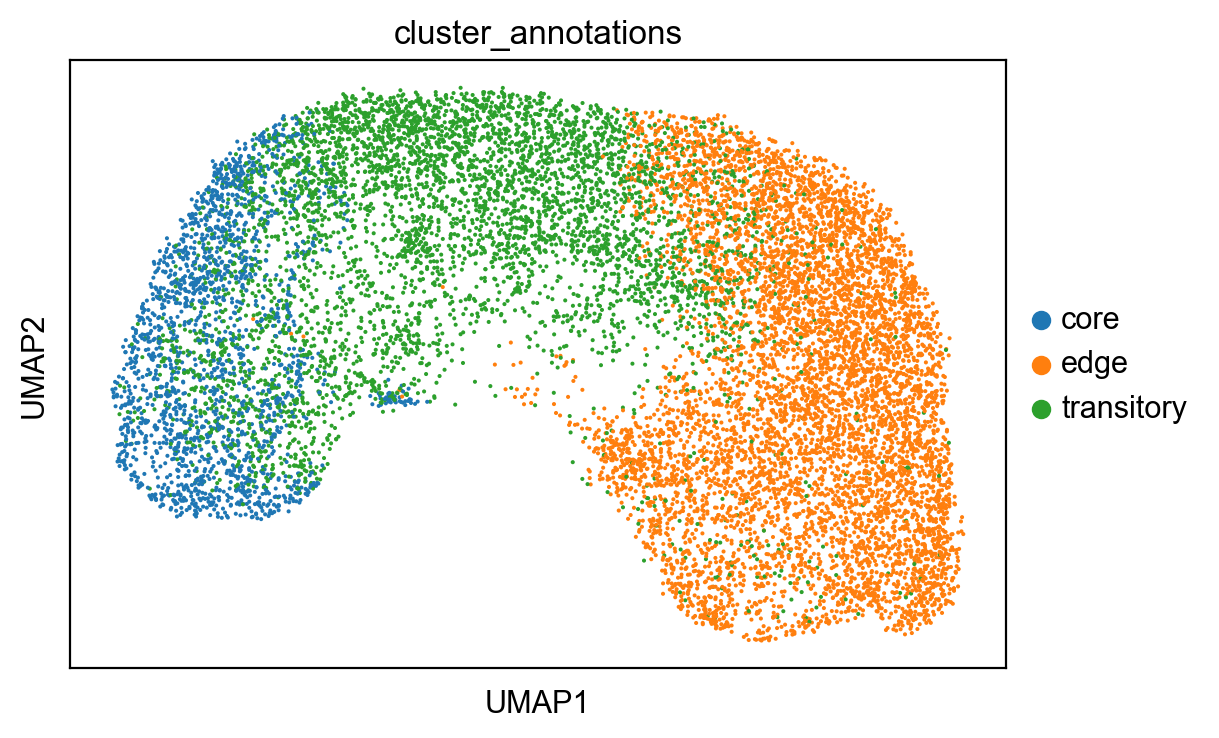

In [27]:
sc.pl.umap(adata, color=['cluster_annotations'])

In [28]:
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata,n_pcs=10, n_neighbors=30)
scv.tl.recover_dynamics(adata,n_jobs = 10)
scv.tl.velocity_graph(adata)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)
scv.tl.latent_time(adata)
scv.tl.velocity_confidence(adata)

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:10) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 10/10 cores)


  0%|          | 0/1968 [00:00<?, ?gene/s]

    finished (0:12:59) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:01:21) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/13949 [00:00<?, ?cells/s]

    finished (0:00:19) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities
    finished (0:00:46) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/13949 [00:00<?, ?cells/s]

    finished (0:00:16) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 7 regions of root cells and 5 regions of end points .
    finished (0:00:08) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:35) --> added 
    'latent_time', shared time (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


saving figure to file plots/vector_confidence.png


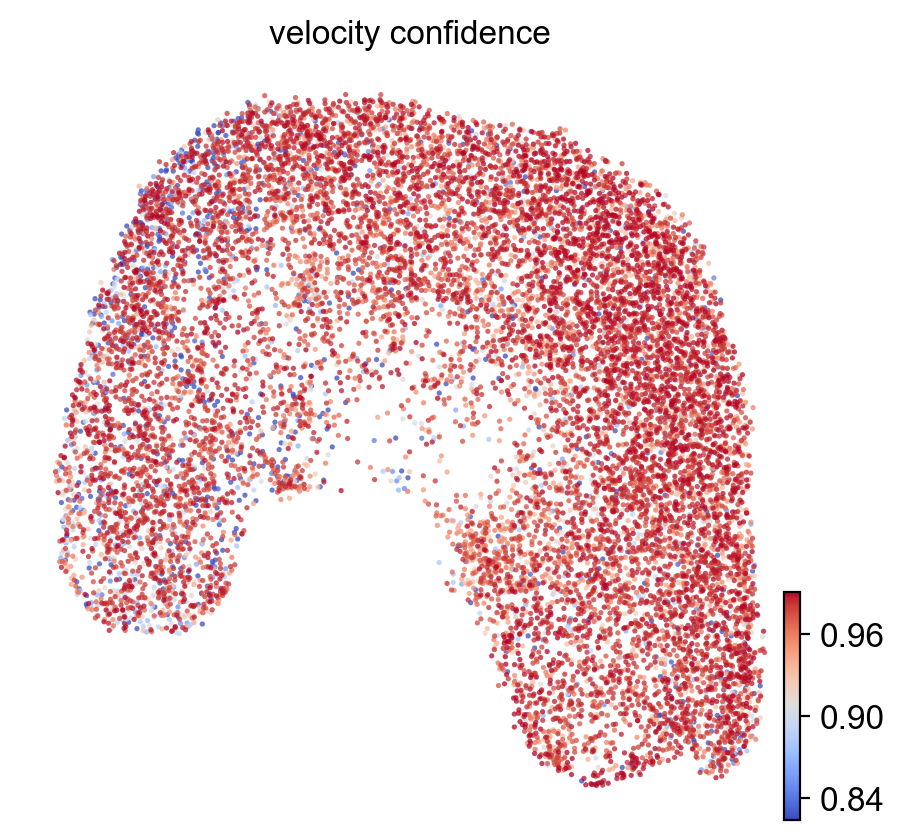

In [30]:
scv.pl.scatter(adata, c='velocity_confidence', cmap='coolwarm', perc=[5, 95], basis = "umap",figsize=(5,5),
                                alpha= 0.75, save=f"plots/vector_confidence.png")

In [ ]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color='cluster_annotations',
                                 palette = ["#4DBBD5FF","#E64B35FF","#F9E076"],
                                size = 50, arrow_size=1.2,
                                save=f"plots/vector.png",dpi = 300,legend_loc='none', figsize=(5,5),
                                alpha= 0.75)

In [ ]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:100]
scv.tl.differential_kinetic_test(adata, var_names=top_genes, groupby='cluster_annotations')

In [ ]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False)

In [ ]:
adata.var['fit_diff_kinetics'].sort_values(ascending=False).to_csv("diff_kinetics.csv")

In [ ]:
top_genes.to_csv("top_genes_diff_splice.csv")

In [ ]:
#differnetial splicing plots
scv.pl.scatter(adata, basis='CSTA', ncols=1, frameon=True,color='cluster_annotations', 
               add_outline='fit_diff_kinetics', fontsize= 15,
               save=f"splicing_diagrams/CSTA.png",dpi = 300,legend_loc='none', figsize=(5,5))
scv.pl.scatter(adata, basis='IGHG3', ncols=1, frameon=True,color='cluster_annotations', 
               add_outline='fit_diff_kinetics', fontsize= 15,
               save=f"splicing_diagrams/IGHG3.png",dpi = 300,legend_loc='none', figsize=(5,5))
scv.pl.scatter(adata, basis='RPS21', ncols=1, frameon=True,color='cluster_annotations', 
               add_outline='fit_diff_kinetics', fontsize= 15,
               save=f"splicing_diagrams/RPS21.png",dpi = 300,legend_loc='none', figsize=(5,5))

scv.pl.scatter(adata, basis='S100A2', ncols=1, frameon=True,color='cluster_annotations', 
               add_outline='fit_diff_kinetics', fontsize= 15,
               save=f"splicing_diagrams/S100A2.png",dpi = 300,legend_loc='none', figsize=(5,5))
scv.pl.scatter(adata, basis='SMIM22', ncols=1, frameon=True,color='cluster_annotations', 
               add_outline='fit_diff_kinetics', fontsize= 15,
               save=f"splicing_diagrams/SMIM22.png",dpi = 300,legend_loc='none', figsize=(5,5))
scv.pl.scatter(adata, basis='RPS4Y1', ncols=1, frameon=True,color='cluster_annotations', 
               add_outline='fit_diff_kinetics', fontsize= 15,
               save=f"splicing_diagrams/RPS4Y1.png",dpi = 300,legend_loc='none', figsize=(5,5))